### Analysis of the scraped data

#### Fossil fuel and renewables data cleaning, aggregating and plotting (all in thousands of megawatthours)

 - Fossil and renewable energy data both show net generation per month, by energy source
 - See Spider files for exactly what is included under each heading

In [1]:
import numpy as np
from scipy import stats
import pandas as pd

from pathlib import Path
import statsmodels.api as sm
from pylab import rcParams
import re

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import plotly
plotly.tools.set_credentials_file(username='scollier95', api_key='fPWI7fnBxIFigL28FW7m')
#plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import colorlover as cl

###### Read in data from the scraped csv's

In [2]:
old_renewable_data_path = Path("renewable_energy_old/RenewableEnergyOld.csv")
renewable_generation = pd.read_csv(old_renewable_data_path, index_col = 5)

old_fossil_data_path = Path("fossil_energy_old/FossilEnergyOld.csv")
fossil_fuel_generation = pd.read_csv(old_fossil_data_path, index_col = 4)

In [3]:
new_renewable_data_path = Path("renewable_energy_new/RenewableEnergyNew.csv")
renewable_generation = renewable_generation.append(pd.read_csv(new_renewable_data_path, index_col = 5))

new_fossil_data_path = Path("fossil_energy_new/FossilEnergyNew.csv")
fossil_fuel_generation = fossil_fuel_generation.append(pd.read_csv(new_fossil_data_path, index_col = 4))

In [4]:
fossil_fuel_generation.drop_duplicates(inplace = True)

In [5]:
print(fossil_fuel_generation.shape)
print(fossil_fuel_generation.head(1))
print(fossil_fuel_generation.tail(1))
print(renewable_generation.shape)
print(renewable_generation.head(1))
print(renewable_generation.tail(1))

(49, 6)
                coal  natural_gas  nuclear  other_gas  petro_coke  \
period                                                              
January 2015  132451       101687    74270       1246        1046   

              petro_liquids  
period                       
January 2015           1927  
                coal  natural_gas  nuclear  other_gas  petro_coke  \
period                                                              
January 2019  101019       118935    73701        994         820   

              petro_liquids  
period                       
January 2019           1316  
(49, 10)
              bmsw  geothermal  hydro  landfill_gas  other_waste  \
period                                                             
January 2015   582        1362  24138           885          258   

              solar_thermal  solarpv_small  solarpv_utility   wind  wood  
period                                                                    
January 2015             63     

In [6]:
print(fossil_fuel_generation.dtypes)
print(renewable_generation.dtypes)

coal             int64
natural_gas      int64
nuclear          int64
other_gas        int64
petro_coke       int64
petro_liquids    int64
dtype: object
bmsw               int64
geothermal         int64
hydro              int64
landfill_gas       int64
other_waste        int64
solar_thermal      int64
solarpv_small      int64
solarpv_utility    int64
wind               int64
wood               int64
dtype: object


In [5]:
# Join the tables to make a plot featuring all of the main energy sources
energy_gen = pd.merge(fossil_fuel_generation,renewable_generation, how = 'inner', left_index = True, right_index = True)

In [6]:
# Following Plot.ly example for filled area plot, altering xticks and adding chart title and axis labels
x = energy_gen.index.tolist()
linewidth = 1.5
brbg = cl.scales['10']['div']['BrBG']

coal = dict(x=x, y=energy_gen['coal'].tolist(), hoverinfo='x+y', mode='lines', \
            line=dict(width=linewidth, color = brbg[1]), stackgroup='one', name='Coal')

petroleum = dict(x=x, y=(energy_gen['petro_coke']+energy_gen['petro_liquids']).tolist(), \
                 hoverinfo='x+y', mode='lines', line=dict(width=linewidth, color = brbg[3]), name='Petroleum', stackgroup='one')

gas = dict(x=x, y=(energy_gen['natural_gas']+energy_gen['other_gas']).tolist(), \
           hoverinfo='x+y', mode='lines', line=dict(width=linewidth, color = brbg[0]), name = 'Gas', stackgroup='one')

nuclear = dict(x=x, y=energy_gen['nuclear'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[2]), name = 'Nuclear', stackgroup='one')

wind = dict(x=x, y=energy_gen['wind'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-4]), stackgroup='one', name='Wind')

solar = dict(x=x, y=(energy_gen['solarpv_utility']+energy_gen['solarpv_small']+energy_gen['solar_thermal']).tolist(), \
             hoverinfo='x+y', mode='lines',line=dict(width=linewidth, color = brbg[-3]), stackgroup='one', name='Solar')

biomass = dict(x=x, y=(energy_gen['bmsw']+energy_gen['landfill_gas']+energy_gen['other_waste']+energy_gen['wood']).tolist(), \
               hoverinfo='x+y', mode='lines',line=dict(width=linewidth, color = brbg[-2]), stackgroup='one', name='Biomass')

geothermal = dict(x=x, y=energy_gen['geothermal'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-1]), stackgroup='one', name='Geothermal')

hydro = dict(x=x, y=energy_gen['hydro'].tolist(), hoverinfo='x+y', mode='lines',\
            line=dict(width=linewidth, color = brbg[-5]), stackgroup='one', name='Hydro')

data=[gas, coal, nuclear, petroleum, hydro, wind, solar, biomass, geothermal]

labels = ['January 2015', 'January 2016','January 2017','January 2018','January 2019']
tickvals = ['January 2015', 'January 2016','January 2017','January 2018','January 2019']

layout = dict(title = dict(text = 'Monthly energy generation', font = dict(family='calibri', size = 32)),
              xaxis=go.layout.XAxis(ticktext=labels, tickvals=tickvals, title='Month', titlefont = dict(family='calibri', size = 24), tickangle=20, tickfont = dict(family='calibri', size = 18)),
              yaxis = dict(title = '000\'s of megawatt hours', titlefont = dict(family='calibri', size = 24), tickfont= dict(family='calibri', size = 18), exponentformat='e'),
              shapes = [{ 'type':'line', 'x0':'20 January 2017', 'y0':0, 'x1':'20 January 2017', 'y1':420000, \
                            'line':dict(color = '#ff0000', width = 2, dash = 'dashdot')}],
             legend = dict(yanchor = 'middle', y = 0.5, font = dict(family='calibri', size = 20)))
# orientation = 'h', x = 0, y = 1.07,
fig=dict(data=data, layout=layout)
plotly.plotly.iplot(fig, fileopt = 'overwrite', filename = 'filled-area-us-electricity-generation')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~scollier95/0 or inside your plot.ly account where it is named 'filled-area-us-electricity-generation'


C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



 - Looks as if there is an annual pattern in the above data - lets split it before and after Trump was inaugurated, and see if there has been a change in the monthly averages
 - Do this separately for renewables and fossil fuels to make dealing with the gropued tables easier

In [7]:
# For the total energy frame, split it either side of Trump's inauguration,
# get the months as a column on their own, make them categorical so that they 
# retain order

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', \
          'September', 'October', 'November', 'December']

energy_gen['month'] = energy_gen.index.map(lambda x: re.sub('[\d\s]','',x))
energy_gen['month']= pd.Categorical(energy_gen['month'], categories = months, ordered = True)

pre_trump = energy_gen.loc['January 2015':'January 2017']
post_trump = energy_gen.loc['February 2017':]

In [8]:
# Group the two resulting frames to average over the time period for each month, then add
# columns showing the total renewable/fossil energy/nuclear (i.e. summed over the sources, have to delve
# into the MultiIndex object of the grouped data frame)

group_pre_t = pre_trump.groupby('month').agg(['mean'])
group_post_t = post_trump.groupby('month').agg(['mean'])

# Exclude nuclear from the column names, as it is not really renewable or fossil
# Make a vector to index with that selects just the renewable/fossil columns to sum

r_col_logical = [True if i in set(renewable_generation.columns) else False for i in group_pre_t.columns.levels[0]]
group_pre_t['total_renewable'] = group_pre_t.loc[:,r_col_logical].sum(axis = 1)
group_post_t['total_renewable'] = group_post_t.loc[:,r_col_logical].sum(axis = 1)

no_nuclear = group_pre_t.columns.levels[0][group_pre_t.columns.levels[0] != 'nuclear']
f_col_logical = [True if i in set(fossil_fuel_generation.columns) else False for i in no_nuclear]
group_pre_t['total_ff'] = group_pre_t.loc[:,no_nuclear].loc[:,f_col_logical].sum(axis = 1)
group_post_t['total_ff'] = group_post_t.loc[:,no_nuclear].loc[:,f_col_logical].sum(axis = 1)

Now plot the nuclear, total renewable and total fossil fuel monthly average for the two portions of time and see if we can see a big difference

In [11]:

dark2 = cl.scales['6']['qual']['Dark2']
pre_t_ff = go.Scatter(x=months, y = list(group_pre_t['total_ff']), name = 'Pre Trump fossil fuels', \
                      line = dict(color = dark2[0],width = 4))

post_t_ff = go.Scatter(x=months, y = list(group_post_t['total_ff']), name = 'Post Trump fossil fuels', \
                       line = dict(color = dark2[1],width = 4))

data2 = [pre_t_ff, post_t_ff]

layout2 = dict(title = dict(text = 'Pre and post inauguration average fossil fuel generation', font = dict(family='calibri', size = 32)), 
               xaxis = dict(title = 'Month', titlefont = dict(family='calibri', size = 24), tickangle = 35, tickfont = dict(family='calibri', size = 18)),
               yaxis = dict(title = '000\'s of megawatt hours', titlefont = dict(family='calibri', size = 24), tickfont= dict(family='calibri', size = 18), exponentformat='e'), 
               legend = dict(orientation = 'h', yanchor = 'bottom', xanchor = 'center', x = 0.5, y = 1, font = dict(family='calibri', size = 20)))

fig2 = dict(data=data2, layout=layout2)
# plotly.offline.iplot(fig2)
plotly.plotly.iplot(fig2, fileopt = 'overwrite', filename = 'pre-and-post-trump-ff-gen')

C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [12]:
dark2 = cl.scales['6']['qual']['Dark2']

pre_t_r = go.Scatter(x=months, y = list(group_pre_t['total_renewable']), name = 'Pre Trump<br>renewables', \
                       line = dict(color = dark2[2],width = 4))

post_t_r = go.Scatter(x=months, y = list(group_post_t['total_renewable']), name = 'Post Trump<br>renewables', \
                       line = dict(color = dark2[3],width = 4))

pre_t_n = go.Scatter(x=months, y = list(group_pre_t['nuclear']['mean']), name = 'Pre Trump<br>nuclear', \
                       line = dict(color = dark2[4],width = 4))

post_t_n = go.Scatter(x=months, y = list(group_post_t['nuclear']['mean']), name = 'Post Trump<br>nuclear', \
                       line = dict(color = dark2[5],width = 4))
data3 = [post_t_n, pre_t_n, post_t_r, pre_t_r]

layout3 = dict(title = dict(text = 'Pre and post inauguration <br> average renewable and nuclear generation', font = dict(family='calibri', size = 30)),
               xaxis = dict(title = 'Month', titlefont = dict(family='calibri', size = 24), tickangle = 35, tickfont = dict(family='calibri', size = 18)),
               yaxis = dict(title = '000\'s of megawatt hours', titlefont = dict(family='calibri', size = 24), tickfont= dict(family='calibri', size = 18), exponentformat='e'),
               legend = dict(yanchor = 'middle', y = 0.5, font = dict(family='calibri', size = 20)))

fig3= dict(data=data3, layout=layout3)
# plotly.offline.iplot(fig3)
plotly.plotly.iplot(fig3, fileopt = 'overwrite', filename = 'pre-and-post-trump-renewable-and-nuclear-gen')

C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



 - Doesn't seem to be much difference! In fact, looks like post-Trump there has been an average decrease in fossil fuel generation, and an average increase in renewable generation.
 - Use statistical tests to see if this difference is significant, need to check they are applicable before using them

In [9]:
renewable_generation['total'] = renewable_generation.sum(axis = 1)
ren_gen_pre_t = renewable_generation.loc['January 2015':'January 2017']
ren_gen_post_t = renewable_generation.loc['February 2017':]

In [10]:
fossil_fuel_generation['total'] = fossil_fuel_generation.loc[:,['coal', 'natural_gas', 'other_gas', 'petro_coke', 'petro_liquids']].sum(axis = 1)
fos_gen_pre_t = fossil_fuel_generation.loc['January 2015':'January 2017']
fos_gen_post_t = fossil_fuel_generation.loc['February 2017':]

               total
count      49.000000
mean   220246.469388
std     34752.397561
min    172031.000000
25%    193717.000000
50%    213917.000000
75%    242389.000000
max    293795.000000
median diff from mean: 2.874%


Text(0.5, 1.0, 'Distribution of monthly fossil fuel generation')

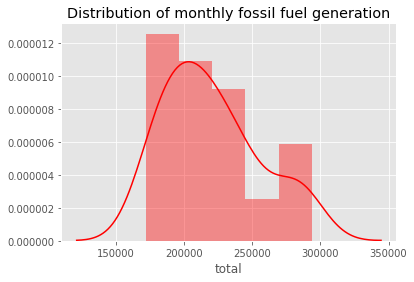

In [28]:
# Make histogram to visually inspect normality - assuming populations are the whole
# sets of renewable and fossil fuel generation data
print(fossil_fuel_generation[['total']].describe())
mean_median_diff_f = round(abs((fossil_fuel_generation['total'].median() - fossil_fuel_generation['total'].mean()) / fossil_fuel_generation['total'].mean())*100, 3)
print('median diff from mean: ' + str(mean_median_diff_f) + "%")
sns.distplot(fossil_fuel_generation['total'],color = 'r').set_title("Distribution of monthly fossil fuel generation")

              total
count     49.000000
mean   55134.428571
std     8012.308318
min    40072.000000
25%    48884.000000
50%    54899.000000
75%    59998.000000
max    70845.000000
median diff from mean: 0.427%


Text(0.5, 1.0, 'Distribution of monthly renewable generation')

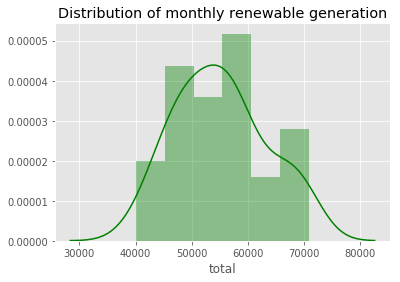

In [27]:
print(renewable_generation[['total']].describe())
mean_median_diff_r = round(abs((renewable_generation['total'].median() - renewable_generation['total'].mean()) / renewable_generation['total'].mean())*100, 3)
print('median diff from mean: ' + str(mean_median_diff_r) + "%")
sns.distplot(renewable_generation['total'],color = 'g').set_title("Distribution of monthly renewable generation")

In [45]:
# Do a Shapiro - Wilk test, which is supposed to be suitable for relatively smaller data sets
# Assumes a null hypothesis that data is normally distributed, low p-value means reject

# PROBLEM IS THAT THIS STILL ASSUMES A PRETTY BIG SAMPLE - small sample sizes, normality tests have 
# little power to reject the null hypothesis and therefore small samples most often pass normality tests
stat1, p1 = stats.shapiro(fossil_fuel_generation['total'])
print("Fossil fuel Shapiro - Wilk p-value: " + str(p1))

stat2, p2 = stats.shapiro(renewable_generation['total'])
print("Renewable Shapiro - Wilk p-value: " + str(p2))

Fossil fuel Shapiro - Wilk p-value: 0.00812461320310831
Renewable Shapiro - Wilk p-value: 0.19853518903255463


In [46]:
# Check with a D'Agostino/Pearson omnibus test (checks for skew and kurtosis):
stat3, p3 = stats.normaltest(fossil_fuel_generation['total'])
print("Fossil fuel D'Agostino/Pearson p-value: " + str(p3))

stat4, p4 = stats.normaltest(renewable_generation['total'])
print("Renewable D'Agostino/Pearson p-value: " + str(p4))

Fossil fuel D'Agostino/Pearson p-value: 0.12554101576772528
Renewable D'Agostino/Pearson p-value: 0.29450178486357037


In [44]:
# Check further with a Anderson-Darling test, which tests the null hypothesis 
# that a sample is drawn from a population that follows a particular distribution 
# (normal in this case). If the returned statistic is larger than the critical 
# value then for the corresponding significance level, the null hypothesis that 
# the data come from the chosen distribution can be rejected.
stat5, crit_val_f, sig_level_f = stats.anderson(fossil_fuel_generation['total'])
print("Fossil fuel Anderson-Darling:\n" + "Statistic: " + str(round(stat5,3)) + "\nCritical values: " + str(crit_val_f) + "\nSignificance level: " + str(sig_level_f) +"\n")

stat6, crit_val_r, sig_level_r = stats.anderson(renewable_generation['total'])
print("Renewable Anderson-Darling:\n" + "Statistic: " + str(round(stat6,3)) + "\nCritical values: " + str(crit_val_r) + "\nSignificance level: " + str(sig_level_r))

Fossil fuel Anderson-Darling:
Statistic: 0.923
Critical values: [0.538 0.612 0.735 0.857 1.019]
Significance level: [15.  10.   5.   2.5  1. ]

Renewable Anderson-Darling:
Statistic: 0.435
Critical values: [0.538 0.612 0.735 0.857 1.019]
Significance level: [15.  10.   5.   2.5  1. ]


 - Neither distribution looks particularly normal, though the renewable generation is definitely less skewed, and it's mean and median are more similar
 - Shapiro - Wilk sugests we reject H0 of a gaussian distribution for fossil fuel generation, but fail to reject it for renewables (alpha = 5%)
 - D'Agostino and Pearson fails to reject the null hypothesis of a normal distribution for either source
 - Anderson - Darling:
      - finds that for fossil fuels, 4/5 of the sig levels tested end up rejecting the nul' hypothesis that the data is normal
      - finds that for renewables, at all of the significance levels the null hypothesis of normality cannot be rejected

**On balance, I am going to move forward assuming the renewable generation to be normally distributed, but for fossil fuels I will NOT make that assumption**

As such, perform a two sample t-test on the renewable data to compare either side of T-day, essentially taking the data sets either side of the split as samples from the population of all of the data. Note the assumptions:
 - Satisfied: The populations from which the samples are drawn are normally dist 
 - Not neccessary: The standard deviations of the two populations are equal.
 - Hmm....: Sample observations are randomly drawn and independent.

In [62]:
# Welch's two sample t-test comparing means of renewable generation time series before and after T-Day
stats.ttest_ind(np.array(ren_gen_pre_t['total']), np.array(ren_gen_post_t['total']), equal_var = False)

Ttest_indResult(statistic=-6.594688768711309, pvalue=4.50831416284386e-08)

 - p-value well below threshold, therefore **reject the null hypothesis that the mean renewable generation before and after Trump's inauguration is the same** 

 For the fossil-fuel generation, need to use the Mann-Whitney U test, a non-parametric test for the null hypothesis that two independent samples were selected from populations having the same mean (equivalent to t-test with no normality assumption, but less powerful)
 
 Assumptions:
  - Hmm...: Independent observations
  - Satisfied: Ordinal observations
  - Equal population distributions of both samples under H0 
  - H1 is that population distributions are not equal

In [71]:
stats.mannwhitneyu(np.array(fos_gen_pre_t['total']), np.array(fos_gen_post_t['total']), alternative = 'two-sided', )

MannwhitneyuResult(statistic=340.0, pvalue=0.42952776832727424)

p-value well above 5% threshold indicates we cannot reject the null hypothesis that the population distributions of both fossil fuel generation samples, either side of T-day, are equal.
**So conclude that there does not appear to have been any statistically significcant change in fossil fuel generation under Trump**

 - Was the renewable generation already on an upward trend before the inauguration? This requires further time series analysis

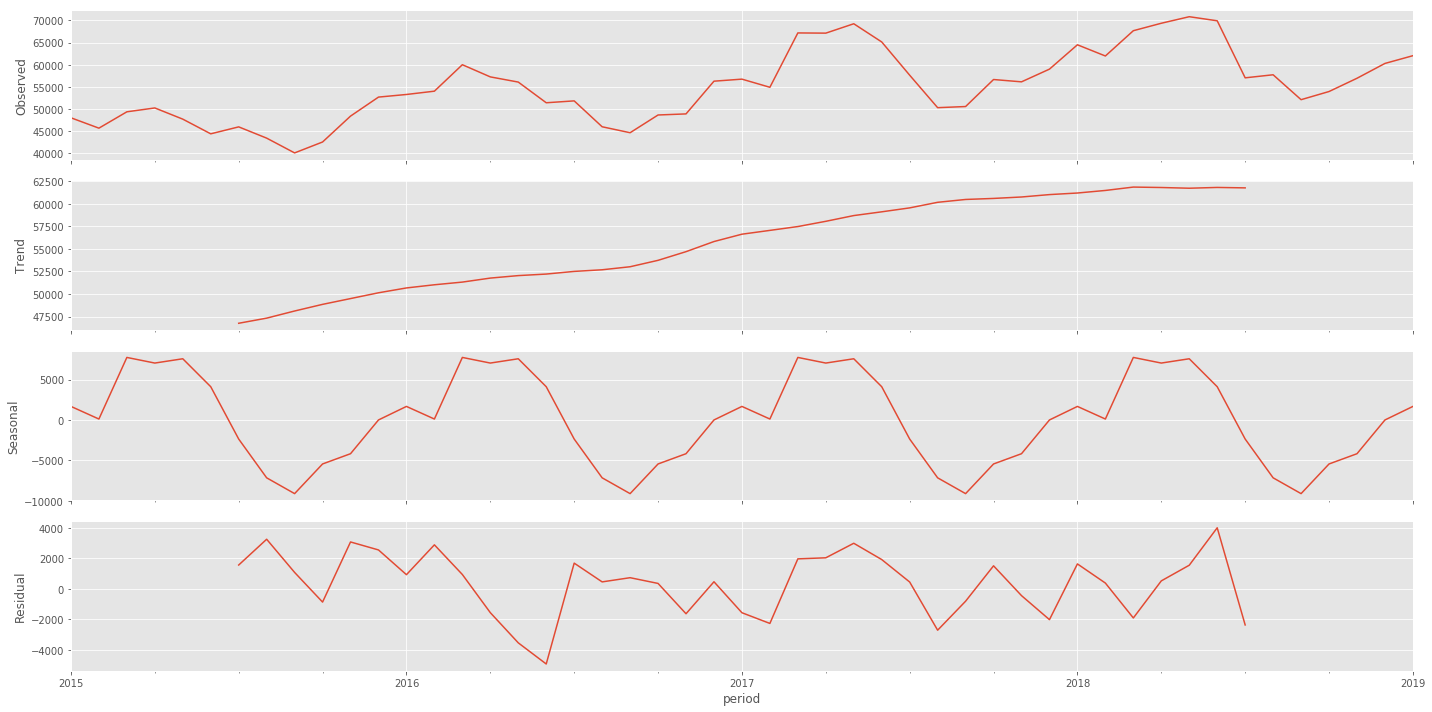

In [85]:
# Make a copy of the renewable generation data frame, changing the index to a datetime to make a timeseries
ren_gen_datetime_index = renewable_generation.copy()
ren_gen_datetime_index.index = pd.to_datetime(ren_gen_datetime_index.index)

# Decompose the time series data into three components
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(ren_gen_datetime_index['total'], model='additive')
fig = decomposition.plot()
plt.show()